# EhV Quality control

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from ehv.core import plot_gate_zarr, plot_gate_zarr_channels
from ehv.masking import plot_scip_segmentation

In [4]:
from umap import UMAP
import time
import math
import pyarrow.parquet as pq
from scip.masking import threshold
from scip.masking import util
from scip.features import texture
import zarr

## SCIP computed features

In [5]:
import os
os.environ["VSC_DATA_VO_USER"]

'/data/gent/vo/000/gvo00070/vsc42015'

## Load processed frame

In [6]:
df = pq.read_table("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202201111300/features.parquet").to_pandas()

## Exploring NaN values

In [7]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(128898, 1344)

In [8]:
# show all NaN columns
df.columns[df.isna().all(axis=0)]

Index([], dtype='object')

Many NaN values occur for features that have no default value for when no mask is found. This occurs in texture and shape features.

In [9]:
def compute_glcm(r, bbox_channel_index=0, smooth=0.75):
    z = zarr.open(r.meta_path)
    pixels = z[r.meta_zarr_idx].reshape(z.attrs["shape"][r.meta_zarr_idx])
    pixels = numpy.clip(pixels, a_min=0, a_max=4096)

    m = threshold.get_mask(dict(pixels=pixels), main=True, main_channel=bbox_channel_index, smooth=smooth)
    m = util.get_bounding_box(m)
    m = threshold.get_mask(m, main=False, main_channel=bbox_channel_index, smooth=smooth)
    m = util.remove_regions_touching_border(m, bbox_channel_index=bbox_channel_index)
    m = util.apply(m)

    fig, axes = plt.subplots(2, len(pixels), dpi=150, squeeze=False)
    for i, (a, p) in enumerate(zip(m["mask"], pixels)):
        axes[0, i].imshow(a)
        axes[0, i].set_axis_off()
        axes[1, i].imshow(p)
        axes[1, i].set_axis_off()
        
    m = texture.texture_features(m, 4096)
        
    return m, fig

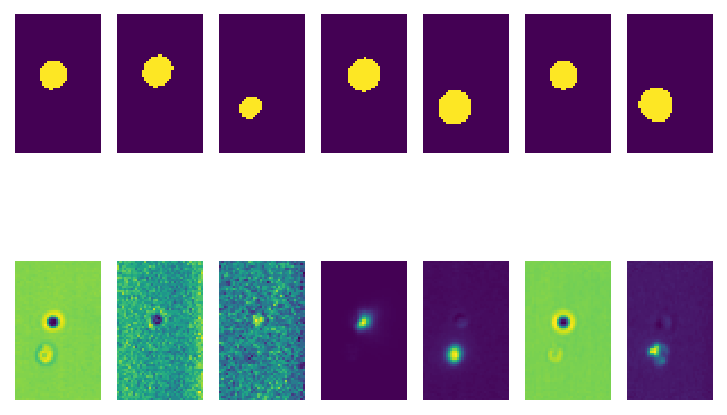

In [10]:
r = df[df.filter(regex="glcm").isna().any(axis=1)].iloc[0]
m, fig = compute_glcm(r, smooth=1.5)

In [11]:
cols = df.filter(regex="glcm").columns[df.filter(regex="glcm").isna().any()]

In [12]:
glcms = pandas.DataFrame(list(map(lambda a: re.match(r"feat_?(?P<comb>combined)?_glcm_(?P<type>[^_]+)_(?P<name>[^_]+)_(?P<dist>[0-9])_(?P<channel>.+)$", a).groupdict(), cols)))

In [13]:
glcms["channel"].unique()

array(['BF1', 'TMR', 'SSC', 'BF2'], dtype=object)

In [14]:
glcms["dist"].value_counts()

5    24
3    20
Name: dist, dtype: int64

In [15]:
glcms.groupby("dist")["type"].value_counts()

dist  type
3     mean    10
      std     10
5     std     13
      mean    11
Name: type, dtype: int64

In [16]:
glcms.groupby("dist")["name"].value_counts()

dist  name         
3     ASM              5
      contrast         4
      correlation      4
      dissimilarity    3
      homogeneity      3
      energy           1
5     correlation      5
      dissimilarity    5
      ASM              4
      contrast         4
      energy           3
      homogeneity      3
Name: name, dtype: int64

In [17]:
glcms.groupby("channel")["name"].value_counts()

channel  name         
BF1      correlation      2
         dissimilarity    2
         energy           2
         homogeneity      2
         ASM              1
BF2      contrast         4
         dissimilarity    4
         homogeneity      4
SSC      ASM              4
         contrast         4
         correlation      3
         dissimilarity    2
TMR      ASM              4
         correlation      4
         energy           2
Name: name, dtype: int64

In [18]:
df = df.drop(columns=cols)

In [19]:
cols = df.filter(regex="sobel").columns[df.filter(regex="sobel").isna().any()]

In [20]:
#df = df.drop(columns=cols)

In [21]:
df["meta_label"].value_counts()

mcp-_psba+    104814
mcp+_psba-      7956
mcp-_psba-      5624
mcp+_psba+      5545
unknown         4959
Name: meta_label, dtype: int64

# Identifying zero-variance features

In [9]:
v = df.filter(regex="feat").var()

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/pandas/core/nanops.py:933: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


In [10]:
v.isna().sum()

0

In [11]:
low_var = df.filter(regex="feat").columns[df.filter(regex="feat").var() < 0.001]

In [12]:
low_var

Index(['feat_solidity_BF1', 'feat_moments_central-0-1_BF1',
       'feat_moments_central-1-0_BF1', 'feat_moments_hu-0_BF1',
       'feat_moments_hu-1_BF1', 'feat_moments_hu-2_BF1',
       'feat_moments_hu-3_BF1', 'feat_moments_hu-4_BF1',
       'feat_moments_hu-5_BF1', 'feat_moments_hu-6_BF1',
       ...
       'feat_combined_glcm_std_ASM_3_BF2', 'feat_combined_glcm_std_ASM_5_BF2',
       'feat_combined_sobel_min_BF2',
       'feat_combined_glcm_std_homogeneity_3_Cy5',
       'feat_combined_glcm_std_homogeneity_5_Cy5',
       'feat_combined_glcm_std_energy_3_Cy5',
       'feat_combined_glcm_std_energy_5_Cy5',
       'feat_combined_glcm_std_ASM_3_Cy5', 'feat_combined_glcm_std_ASM_5_Cy5',
       'feat_combined_sobel_min_Cy5'],
      dtype='object', length=135)

In [13]:
df = df.drop(columns=low_var)

# Looking at outlier feature values

In [14]:
from scipy.stats import normaltest
from sklearn.preprocessing import PowerTransformer

In [26]:
for col in df.filter(regex="feat"):
    r = normaltest(df[col])
    if r.pvalue > 0.05:
        print(col)

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/scipy/stats/stats.py:955: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/scipy/stats/stats.py:959: RuntimeWarning: overflow encountered in square
  s = s**2
/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/scipy/stats/stats.py:961: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean


In [27]:
for col in df.filter(regex="feat"):
    if df[col].min() >= 0:
        r = normaltest(numpy.log(df[col]))
        if r.pvalue > 0.05:
            print(col)

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/scipy/stats/stats.py:951: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


### Inter-quatile range

In [28]:
cols, amount = [], []
for col in df.filter(regex="feat"):
    q1, q3 = numpy.percentile(df[col], [25, 75])
    cutoff = q3 + (q3-q1)*1.5
    a = (df[col] > cutoff).sum()
    if a > 0:
        cols.append(col)
        amount.append(a)
        
amount = numpy.array(amount)
cols = numpy.array(cols)

In [63]:
cols

array(['feat_area_BF1', 'feat_convex_area_BF1', 'feat_eccentricity_BF1',
       'feat_equivalent_diameter_BF1', 'feat_feret_diameter_max_BF1',
       'feat_filled_area_BF1', 'feat_major_axis_length_BF1',
       'feat_minor_axis_length_BF1', 'feat_perimeter_BF1',
       'feat_perimeter_crofton_BF1', 'feat_inertia_tensor-0-0_BF1',
       'feat_inertia_tensor-0-1_BF1', 'feat_inertia_tensor-1-0_BF1',
       'feat_inertia_tensor-1-1_BF1', 'feat_inertia_tensor_eigvals-0_BF1',
       'feat_inertia_tensor_eigvals-1_BF1', 'feat_moments-0-0_BF1',
       'feat_moments-0-1_BF1', 'feat_moments-0-2_BF1',
       'feat_moments-0-3_BF1', 'feat_moments-1-0_BF1',
       'feat_moments-1-1_BF1', 'feat_moments-1-2_BF1',
       'feat_moments-1-3_BF1', 'feat_moments-2-0_BF1',
       'feat_moments-2-1_BF1', 'feat_moments-2-2_BF1',
       'feat_moments-2-3_BF1', 'feat_moments-3-0_BF1',
       'feat_moments-3-1_BF1', 'feat_moments-3-2_BF1',
       'feat_moments-3-3_BF1', 'feat_moments_central-0-0_BF1',
       'f

(array([230., 147., 165.,  96.,  69.,  86.,  42.,  14.,  18.,  31.]),
 array([1.00000e+00, 1.71430e+03, 3.42760e+03, 5.14090e+03, 6.85420e+03,
        8.56750e+03, 1.02808e+04, 1.19941e+04, 1.37074e+04, 1.54207e+04,
        1.71340e+04]),
 <a list of 10 Patch objects>)

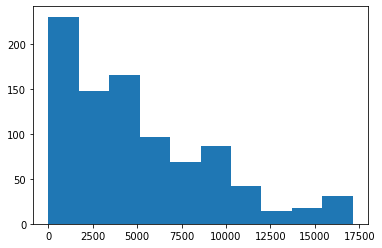

In [29]:
plt.hist(amount)

In [58]:
u, c = numpy.unique(amount, return_counts=True)

In [30]:
tmp = cols[numpy.where(amount > 15000)]

In [31]:
tmp[0]

'feat_std_TMR'

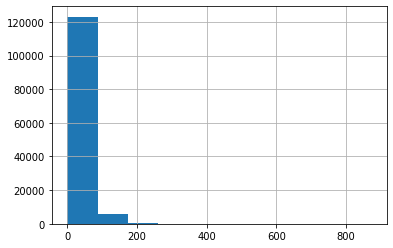

In [32]:
df[tmp[0]].hist()

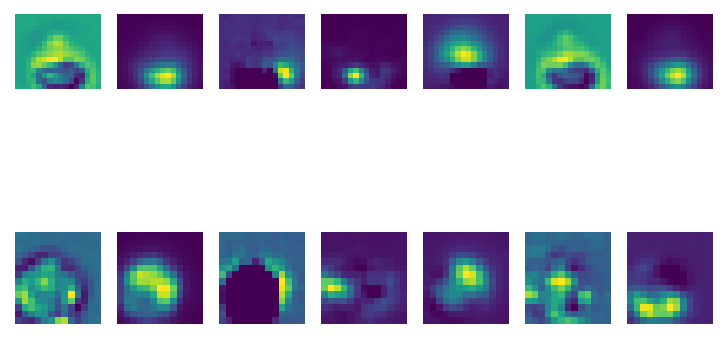

In [34]:
sel1 = df[tmp[0]] > 400
plot_gate_zarr_channels(sel1, df)

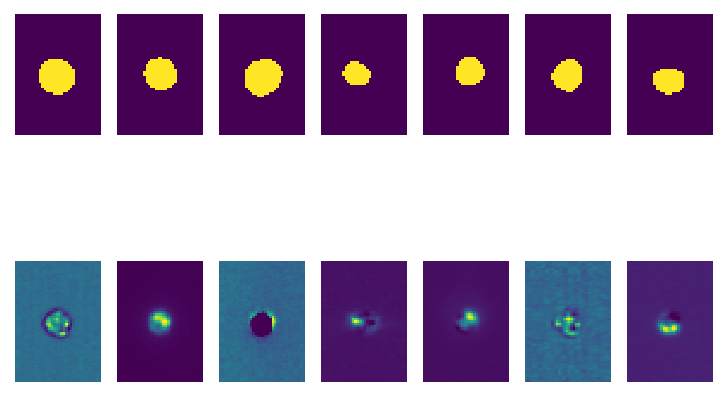

In [39]:
out = plot_scip_segmentation(df[sel1].iloc[1])

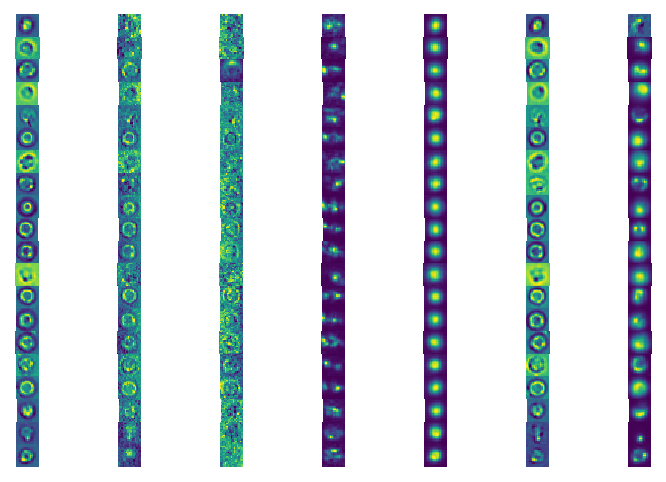

In [44]:
sel1 = df[tmp[0]] < 50
plot_gate_zarr_channels(sel1, df)

In [57]:
tmp

array(['feat_std_TMR', 'feat_mad_TMR', 'feat_modulation_TMR',
       'feat_bgcorr_mean_TMR', 'feat_bgcorr_median_TMR',
       'feat_bgcorr_max_TMR', 'feat_bgcorr_std_TMR',
       'feat_bgcorr_mad_TMR', 'feat_bgcorr_upper_quartile_TMR',
       'feat_bgcorr_sum_TMR', 'feat_edge_std_TMR', 'feat_edge_mad_TMR',
       'feat_edge_modulation_TMR', 'feat_bgcorr_edge_mean_TMR',
       'feat_bgcorr_edge_median_TMR', 'feat_bgcorr_edge_max_TMR',
       'feat_bgcorr_edge_std_TMR', 'feat_bgcorr_edge_mad_TMR',
       'feat_bgcorr_edge_upper_quartile_TMR', 'feat_bgcorr_edge_sum_TMR',
       'feat_combined_std_TMR', 'feat_combined_modulation_TMR',
       'feat_combined_bgcorr_mean_TMR', 'feat_combined_bgcorr_max_TMR',
       'feat_combined_bgcorr_std_TMR',
       'feat_combined_bgcorr_upper_quartile_TMR',
       'feat_combined_bgcorr_sum_TMR', 'feat_combined_edge_std_TMR',
       'feat_combined_edge_modulation_TMR',
       'feat_combined_bgcorr_edge_mean_TMR',
       'feat_combined_bgcorr_edge_max_TMR'

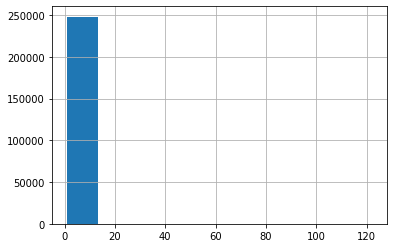

In [147]:
df[tmp[1]].hist()

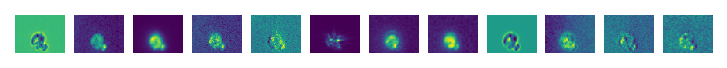

In [141]:
sel1 = df[tmp[1]] > 20
plot_gate_zarr_channels(sel1, df)

In [64]:
tmp[2]

'feat_modulation_TMR'

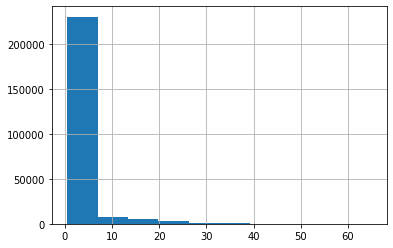

In [149]:
df[tmp[2]].hist()

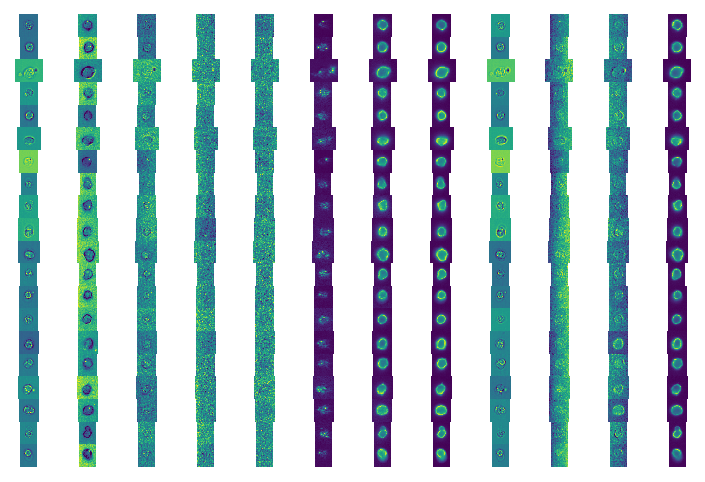

In [150]:
sel1 = df[tmp[2feat_moments_hufeat_moments_hu]] > 40
plot_gate_zarr_channels(sel1, df)

### normalized variance

In [15]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

In [16]:
inf_features = norm_var[norm_var.abs() == numpy.inf]

In [17]:
df["feat_combined_bgcorr_edge_lower_quartile_TMR"].describe()

count     1.288980e+05
mean     4.555619e+223
std                inf
min      -1.348281e+01
25%      -2.601634e+00
50%      -1.440246e+00
75%      -4.575528e-01
max      5.872102e+228
Name: feat_combined_bgcorr_edge_lower_quartile_TMR, dtype: float64

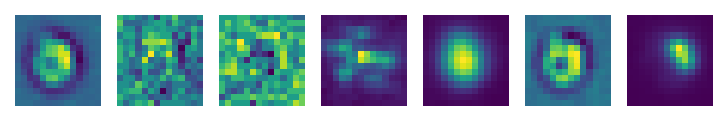

In [18]:
sel1 = df["feat_combined_bgcorr_edge_lower_quartile_TMR"] > 1e6
plot_gate_zarr_channels(sel1, df)

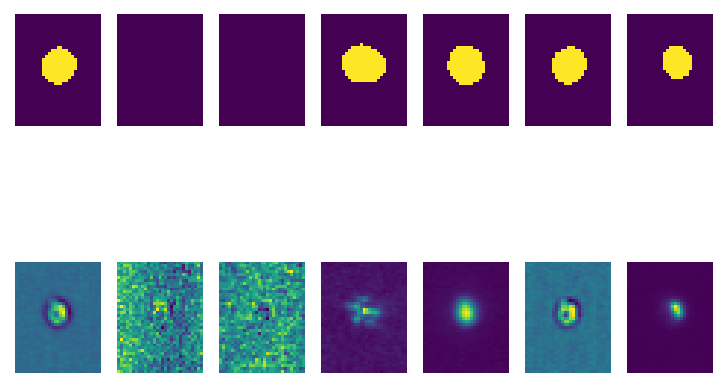

In [19]:
r = plot_scip_segmentation(df[sel1].iloc[0])

In [20]:
df = df[~sel1]
df.shape

(128897, 1209)

In [21]:
df["feat_glcm_mean_ASM_3_SSC"].describe()

count     1.288890e+05
mean     2.700428e+247
std                inf
min      -2.570862e+12
25%       6.907146e-02
50%       1.072665e-01
75%       1.959419e-01
max      6.961108e+251
Name: feat_glcm_mean_ASM_3_SSC, dtype: float64

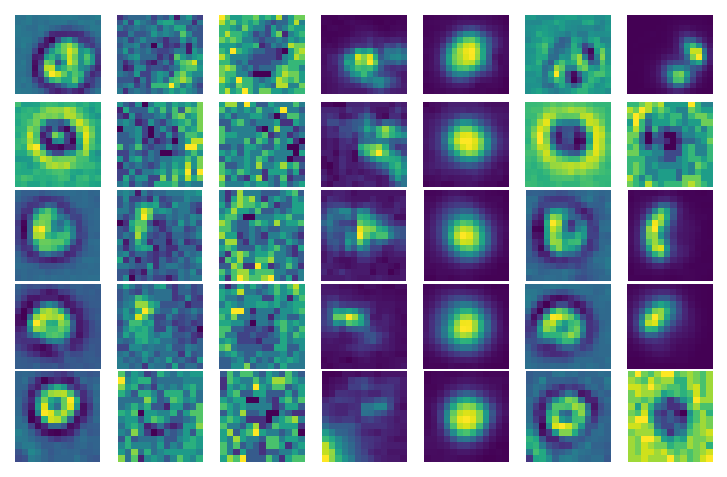

In [22]:
sel1 = df["feat_glcm_mean_ASM_3_SSC"] > 1e100
plot_gate_zarr_channels(sel1, df)

In [23]:
df = df[~sel1]
df.shape

(128892, 1209)

In [24]:
df["feat_glcm_std_dissimilarity_3_BF1"].describe()

count     1.288920e+05
mean    -4.265517e+299
std                inf
min     -5.497911e+304
25%       4.000000e-02
50%       9.183673e-02
75%       1.730769e-01
max       7.711429e+08
Name: feat_glcm_std_dissimilarity_3_BF1, dtype: float64

In [25]:
for f in inf_features.index:
    s = len(df)
    v = df[f].var()
    while abs(v) == numpy.inf:
        if abs(df[f].min()) > abs(df[f].max()):
            df = df.drop(index=df[f].idxmin())
        else:
            df = df.drop(index=df[f].idxmax())
        v = df[f].var()
    print("Dropped %d rows for %s" % (s-len(df), f))

Dropped 1 rows for feat_combined_bgcorr_lower_quartile_TMR
Dropped 0 rows for feat_combined_edge_min_TMR
Dropped 0 rows for feat_combined_bgcorr_edge_lower_quartile_TMR
Dropped 1 rows for feat_glcm_std_dissimilarity_3_BF1
Dropped 0 rows for feat_glcm_mean_homogeneity_3_BF1
Dropped 0 rows for feat_glcm_mean_homogeneity_5_BF1
Dropped 0 rows for feat_glcm_mean_energy_3_BF1
Dropped 0 rows for feat_glcm_std_energy_3_BF1
Dropped 0 rows for feat_glcm_mean_correlation_5_BF1
Dropped 0 rows for feat_glcm_mean_ASM_5_BF1
Dropped 0 rows for feat_glcm_mean_correlation_3_TMR
Dropped 0 rows for feat_glcm_std_homogeneity_5_SSC
Dropped 0 rows for feat_glcm_mean_ASM_3_SSC
Dropped 0 rows for feat_glcm_std_ASM_5_SSC


In [26]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

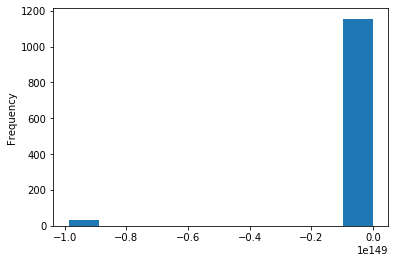

In [27]:
norm_var.plot.hist()

In [28]:
from sklearn.ensemble import IsolationForest

In [29]:
iso = IsolationForest(n_estimators=100, random_state=0, n_jobs=5, contamination=0.05)
iso.fit(
    df.filter(regex="feat")
    .fillna(0)
    .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.05, n_jobs=5, random_state=0)

In [30]:
pred = iso.predict(
    df.filter(regex="feat")
    .fillna(0)
    .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

In [31]:
numpy.unique(pred, return_counts=True)

(array([-1,  1]), array([  6445, 122445]))

In [32]:
norm_var = df[pred == 1].filter(regex="feat").var() / df[pred == 1].filter(regex="feat").mean()

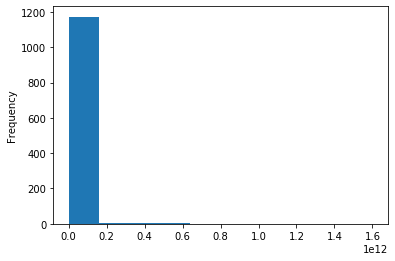

In [33]:
norm_var.plot.hist()

In [34]:
df = df[pred == 1]

# Number of identified regions per channel 

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


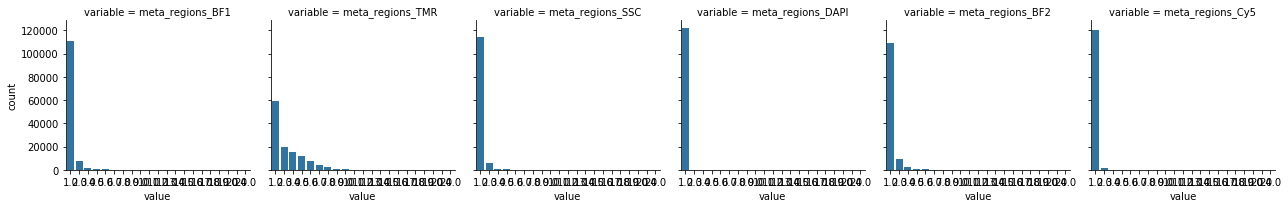

In [35]:
tmp = pandas.melt(df.reset_index(), value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable")
grid.map_dataframe(seaborn.countplot, x="value")

# Detecting multiplets that are missed during segmentation

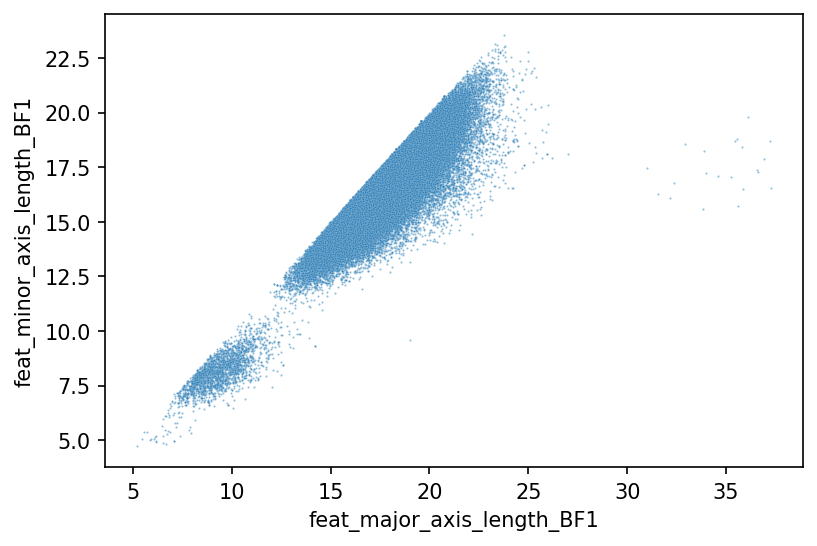

In [36]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_BF1", y="feat_minor_axis_length_BF1", s=1, alpha=0.5, edgecolors="none")

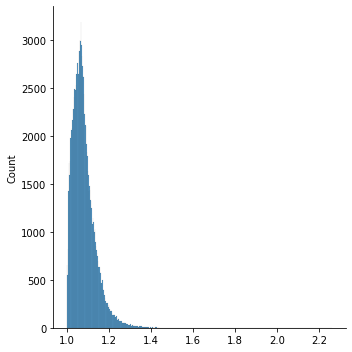

In [37]:
feat_majorminor_ratio = df["feat_major_axis_length_BF1"] / df["feat_minor_axis_length_BF1"]
ax = seaborn.displot(x=feat_majorminor_ratio)

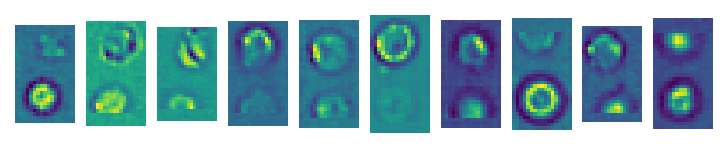

In [38]:
sel1 = feat_majorminor_ratio > 2
plot_gate_zarr(sel1, df)

In [39]:
df = df[~sel1]
df.shape

(122435, 1209)

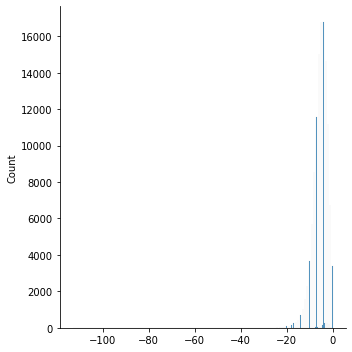

In [40]:
seaborn.displot(data=df["feat_area_BF1"] - df["feat_convex_area_BF1"])

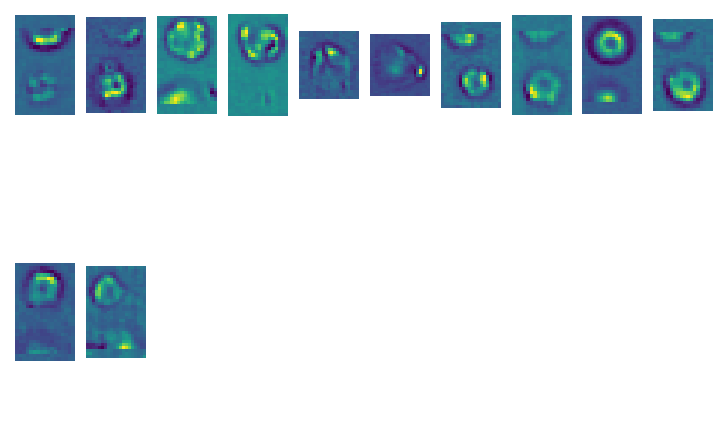

In [41]:
sel1 = (df["feat_area_BF1"] - df["feat_convex_area_BF1"]) < -40
core.plot_gate_zarr(sel1, df)

In [42]:
df = df[~sel1]
df.shape

(122423, 1209)

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


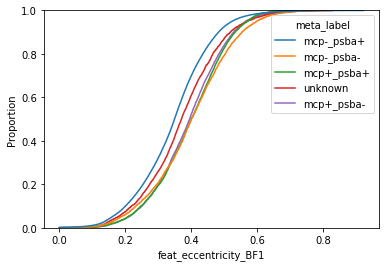

In [43]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_BF1", hue="meta_label")

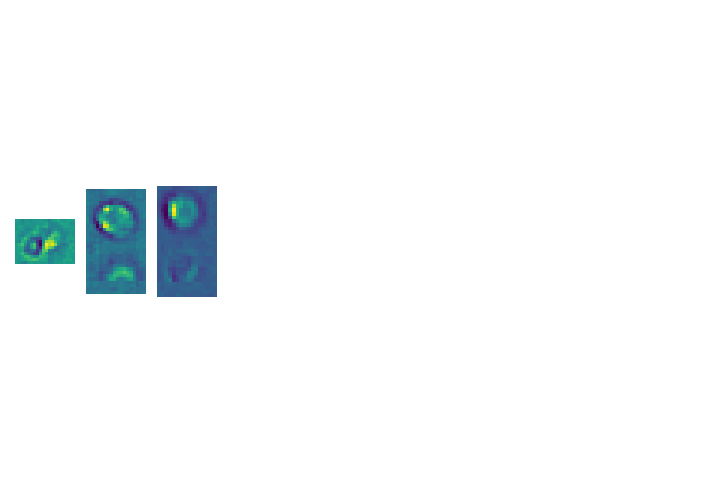

In [44]:
sel1 = df["feat_eccentricity_BF1"] > 0.85
core.plot_gate_zarr(sel1, df)

In [45]:
df = df[~sel1]
df.shape

(122420, 1209)

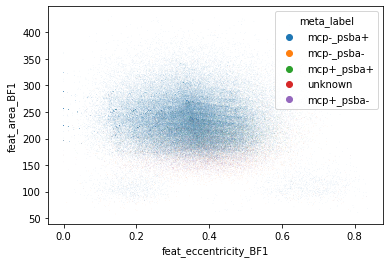

In [46]:
ax = seaborn.scatterplot(data=df, x="feat_eccentricity_BF1", y="feat_area_BF1", s=0.1, alpha=0.5, hue="meta_label")

# Noisy events

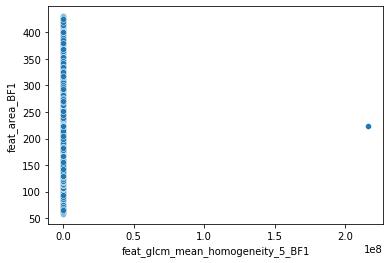

In [49]:
seaborn.scatterplot(data=df, x="feat_glcm_mean_homogeneity_5_BF1", y="feat_area_BF1")

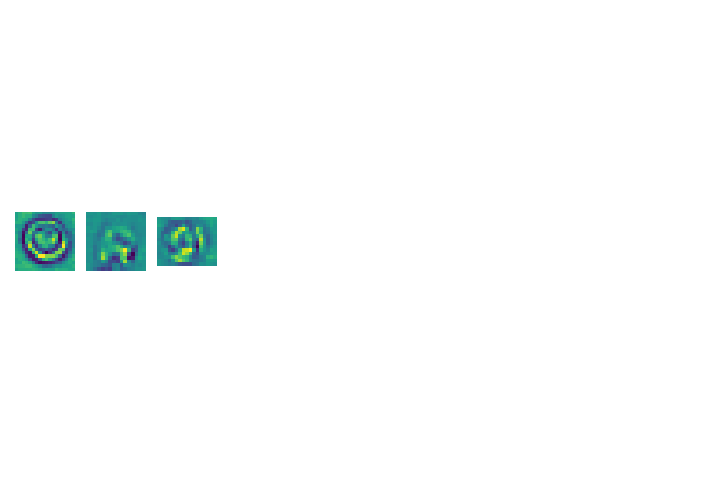

In [53]:
sel1 = df["feat_glcm_mean_homogeneity_5_BF1"] > 1e4
core.plot_gate_zarr(sel1, df)

In [54]:
df = df[~sel1]
df.shape

(122416, 1209)

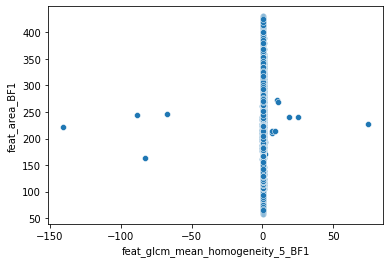

In [55]:
seaborn.scatterplot(data=df, x="feat_glcm_mean_homogeneity_5_BF1", y="feat_area_BF1")

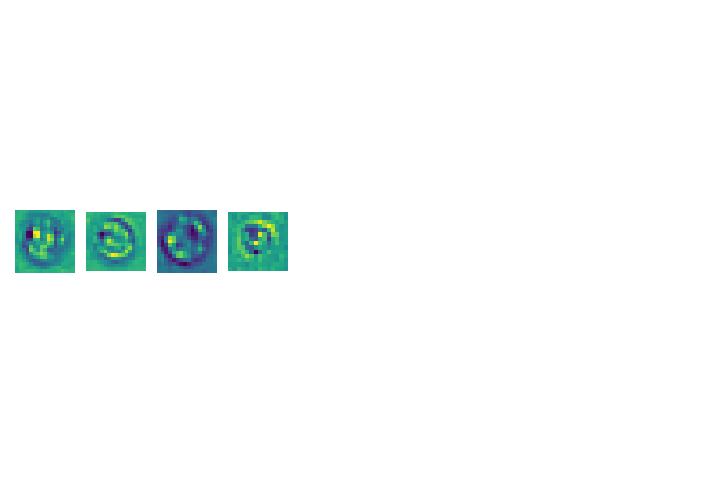

In [56]:
sel1 = df["feat_glcm_mean_homogeneity_5_BF1"] < -50
core.plot_gate_zarr(sel1, df)

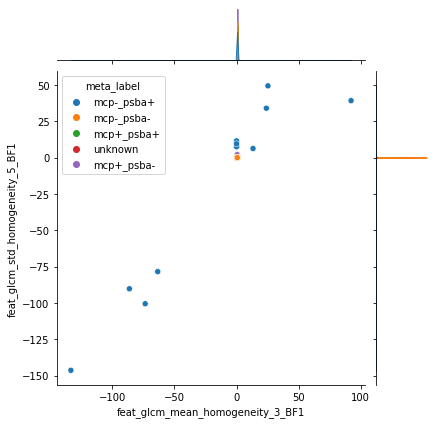

In [57]:
seaborn.jointplot(data=df, x="feat_glcm_mean_homogeneity_3_BF1", y="feat_glcm_std_homogeneity_5_BF1", hue="meta_label")

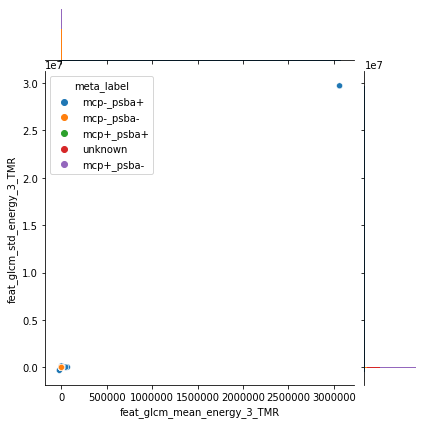

In [59]:
seaborn.jointplot(data=df, x="feat_glcm_mean_energy_3_TMR", y="feat_glcm_std_energy_3_TMR", hue="meta_label")

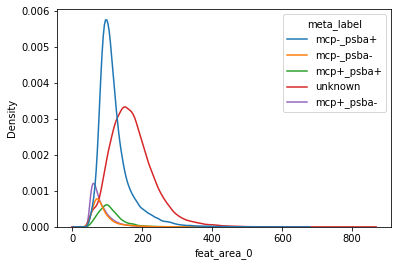

In [229]:
seaborn.kdeplot(data=df, x="feat_area_0", hue="meta_label")

In [230]:
df["meta_label"].value_counts()

unknown       53418
mcp-_psba+    45289
mcp+_psba-     6031
mcp+_psba+     4860
mcp-_psba-     4424
Name: meta_label, dtype: int64

# Feature correlation

In [60]:
correlation = df.filter(regex="feat.*").corr()

## Overall feature correlation

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

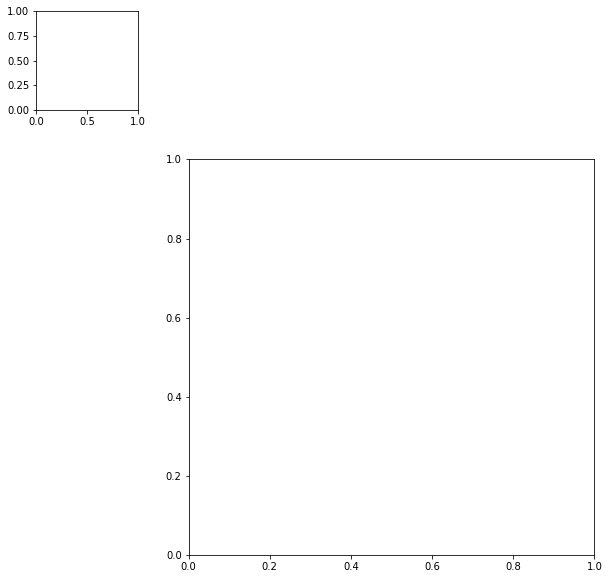

In [61]:
seaborn.clustermap(correlation)

In [157]:
def get_correlated_features(df, cutoff=0.85):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > cutoff:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [158]:
correlated_features = get_correlated_features(df.filter(regex="feat"), cutoff=0.7)
correlation2 = df.filter(regex="feat").drop(columns=correlated_features).corr()

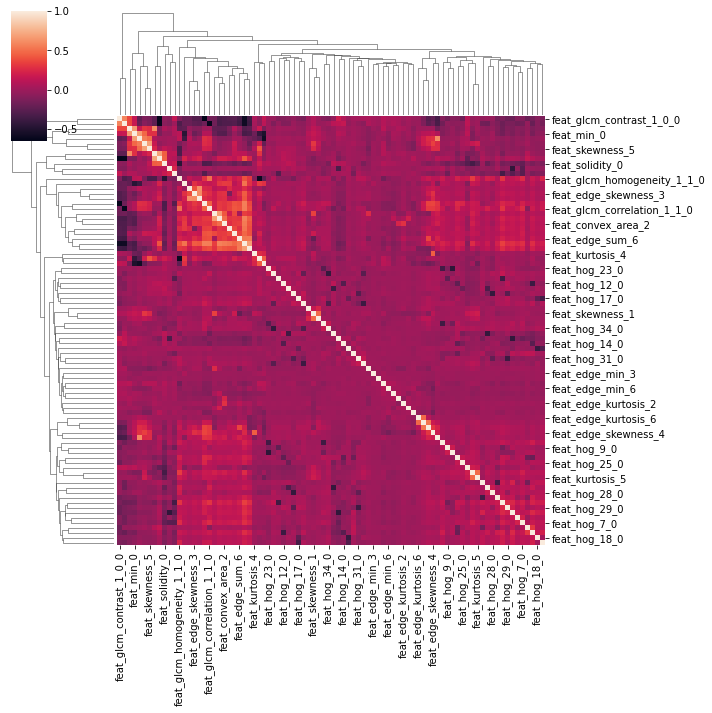

In [159]:
seaborn.clustermap(correlation2)

In [160]:
len(correlated_features)

153

In [161]:
df = df.drop(columns=correlated_features)

In [162]:
df.shape

(58440, 112)

In [163]:
len(df.index.values)

58440

# Export

In [69]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202201111300/index.npy", df.index.values)

In [70]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202201111300/columns.npy", df.columns.values)